<a href="https://colab.research.google.com/github/kargaranamir/umsi/blob/master/umsi_simple_inference_from_full_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UMSI Inference with Tensorflow2

In [2]:
import tensorflow
tensorflow.__version__

'2.8.2'

### Download Model

In [ ]:
! wget http://predimportance.mit.edu/data/xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5

### Downlaod Test images

In [ ]:
! wget https://github.com/diviz-mit/predimportance-public/raw/master/50.jpg
! wget https://github.com/diviz-mit/predimportance-public/raw/master/COCO_val2014_000000001700.jpg

In [4]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import os
from PIL import Image
import scipy


# Tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# choose which image processing library you want to use
use_cv2 = False 
if use_cv2:
    import cv2
else:
    import skimage.transform as skit
# ---------------------------

In [5]:
# Aux functions

# Input shape of the model
shape_r=240
shape_c=320

def padding(img, shape_r, shape_c, channels=3):
    img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)
    if use_cv2:
        original_shape = img.shape
    else:
        original_shape = np.asarray(img).shape
    rows_rate = original_shape[0]/shape_r
    cols_rate = original_shape[1]/shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        if use_cv2:
            img = cv2.resize(img, (new_cols, shape_r))
        else:
            img = img.resize((new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        if use_cv2:
            img = cv2.resize(img, (shape_c, new_rows))
        else:
            img = img.resize((shape_c, new_rows))
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded

def preprocess_images(paths, shape_r, shape_c, pad=True, show=False):
    if pad:
        ims = np.zeros((len(paths), shape_r, shape_c, 3))
    else:
        ims =[]

    for i, path in enumerate(paths):
        if use_cv2:
            original_image = cv2.imread(path)
        else:
            original_image = Image.open(path)
        if original_image is None:
            raise ValueError('Path unreadable: %s' % path)
        if pad:
            padded_image = padding(original_image, shape_r, shape_c, 3)
            ims[i] = padded_image
        else:
            original_image = original_image.astype(np.float32)
            original_image[..., 0] -= 103.939
            original_image[..., 1] -= 116.779
            original_image[..., 2] -= 123.68
            ims.append(original_image)
            ims = np.array(ims)
            print('ims.shape in preprocess_imgs',ims.shape)
            
        if show:
            print("Path:", path)
            plt.figure(figsize=[8,8])
            plt.subplot(1,2,1)
            if use_cv2:
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(original_image)
            plt.title("Original image")
            plt.subplot(1,2,2)
            if use_cv2:
                plt.imshow(cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(padded_image)
            plt.title("Input to network")
            plt.show()

    if pad:
        ims[:, :, :, 0] -= 103.939
        ims[:, :, :, 1] -= 116.779
        ims[:, :, :, 2] -= 123.68

    return ims

def postprocess_predictions(pred, shape_r, shape_c, blur=False, normalize=False):
    predictions_shape = pred.shape
    rows_rate = shape_r / predictions_shape[0]
    cols_rate = shape_c / predictions_shape[1]

    if blur:
        sigma=blur
        pred = scipy.ndimage.filters.gaussian_filter(pred, sigma=sigma)

    if rows_rate > cols_rate:
        new_cols = (predictions_shape[1] * shape_r) // predictions_shape[0]
        if use_cv2:
            pred = cv2.resize(pred, (new_cols, shape_r))
        else:
            pred = skit.resize(pred, (shape_r, new_cols))
        img = pred[:, ((pred.shape[1] - shape_c) // 2):((pred.shape[1] - shape_c) // 2 + shape_c)]
    else:
        new_rows = (predictions_shape[0] * shape_c) // predictions_shape[1]
        if use_cv2:
            pred = cv2.resize(pred, (shape_c, new_rows))
        else:
            pred = skit.resize(pred, (new_rows, shape_c))
        img = pred[((pred.shape[0] - shape_r) // 2):((pred.shape[0] - shape_r) // 2 + shape_r), :]

    if normalize:
        img = img / np.max(img) * 255

    return img


def heatmap_overlay(im,heatmap,colmap='hot'):
    cm_array = cm.get_cmap(colmap)
    im_array = np.asarray(im)
    heatmap_norm = (heatmap-np.min(heatmap))/float(np.max(heatmap)-np.min(heatmap))
    heatmap_hot = cm_array(heatmap_norm)
    res_final = im_array.copy()
    heatmap_rep = np.repeat(heatmap_norm[:, :, np.newaxis], 3, axis=2)
    res_final[...] = heatmap_hot[...,0:3]*255.0*heatmap_rep + im_array[...]*(1-heatmap_rep)
    return res_final

# Load model

In [ ]:
# Load model
# the model can be downloaded from here: http://predimportance.mit.edu/data/xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5
ckpt_path = 'xception_cl_fus_aspp_imp1k_10kl-3cc0.1mse-5nss5bc_bs4_ep30_valloss-2.5774_full.h5' 
    
model = keras.models.load_model(ckpt_path, compile=False, custom_objects={"K": K})

model.summary()

# Load images

Path: 50.jpg


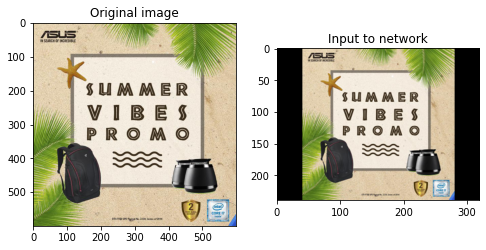

Path: COCO_val2014_000000001700.jpg


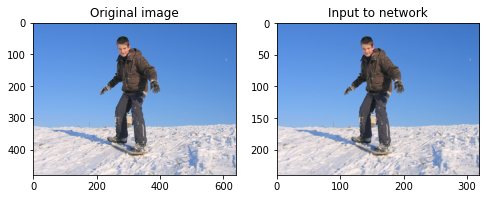

In [8]:
# Fill in the paths for the images you want to test here, natural images or graphic designs (both work!)
img_paths = ['50.jpg','COCO_val2014_000000001700.jpg']

img_batch = preprocess_images(img_paths, shape_r, shape_c, pad=True, show=True)

# Predict maps

In [9]:
pred = model.predict(img_batch)

# Show predictions

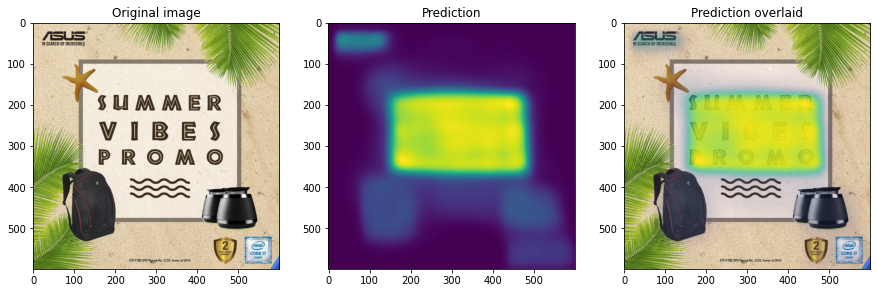

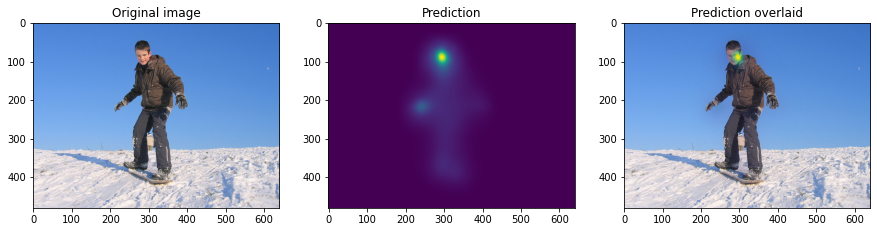

In [10]:
# Fill this in if images have ground truth and you want to see them side by side for comparison
gr_truth_paths = None

if gr_truth_paths is not None: k=4;
else: k=3;


pred_batch=[]
for i in range(len(img_paths)):
    
    # Open original image to get width and height
    im = Image.open(img_paths[i])
    width, height = im.size
    
    # Postprocess to get pred back to original size
    pred_batch.append(postprocess_predictions(pred[0][i,:,:,0], height, width))
    
    # Overlay heatmap on image
    res = heatmap_overlay(im,pred_batch[i],'viridis');
    
    # Show
    plt.figure(figsize=[15,15])
    plt.subplot(1,k,1)
    plt.imshow(im)
    plt.title("Original image")
    plt.subplot(1,k,2)
    plt.imshow(pred_batch[i])
    plt.title("Prediction")
    plt.subplot(1,k,3)
    plt.imshow(res)
    plt.title("Prediction overlaid")
    
    if gr_truth_paths:
        plt.subplot(1,k,4)
        if use_cv2:
            plt.imshow(cv2.imread(gr_truth_paths[i], 0))
        else:
            plt.imshow(Image.open(gr_truth_paths[i]))
        plt.title("Ground truth")
    